In [25]:
import os
import sys
import numpy as np
import pandas as pd
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [14]:
df = pd.read_csv('air-traffic-prediction/parkingLot.csv')


In [15]:

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df = df[df['vehicle_no'].notna()]
df = df.dropna()
df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
df = df.drop_duplicates()
print(df.shape)

(104998, 3)


In [16]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[M][H][0-9]{2}[A-Z]{1,2}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))

ndf=df[df['vehicle_no'].apply(valid_vehicle_no)]
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
21,MHMY1867,2024-09-12 05:00:00,1
20,MHZF8417,2024-09-12 05:00:00,1
19,MHFU6425,2024-09-12 05:00:00,1
18,MHHB4038,2024-09-12 05:00:00,1
...,...,...,...
106658,MHPB1713,2024-11-13 23:40:00,2
106657,MHRN1774,2024-11-13 23:40:00,2
106656,MHNN2256,2024-11-13 23:40:00,2
106655,MHBU1695,2024-11-13 23:40:00,2


In [17]:
entry_df = df[df['camera_id'] == 1]  # Entries (camera_id = 001)
exit_df = df[df['camera_id'] == 2]   # Exits (camera_id = 002)
print(df)
# 2. Rename columns for clarity
entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']], 
                     exit_df[['vehicle_no', 'exit_time']], 
                     on='vehicle_no', 
                     how='left')

merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
merged_df['timestamp_exit'] = pd.to_datetime(arg=merged_df['exit_time'])

# Ensure timestamps are on the same date by comparing just the date part
merged_df = merged_df[
    (merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) &
    (merged_df['in_time'] <= merged_df['exit_time'])
]

merged_df

       vehicle_no           timestamp  camera_id
0        MHUN7063 2024-09-12 05:00:00          1
21       MHMY1867 2024-09-12 05:00:00          1
20       MHZF8417 2024-09-12 05:00:00          1
19       MHFU6425 2024-09-12 05:00:00          1
18       MHHB4038 2024-09-12 05:00:00          1
...           ...                 ...        ...
106658   MHPB1713 2024-11-13 23:40:00          2
106657   MHRN1774 2024-11-13 23:40:00          2
106656   MHNN2256 2024-11-13 23:40:00          2
106655   MHBU1695 2024-11-13 23:40:00          2
106663   MHWW7105 2024-11-13 23:40:00          2

[104998 rows x 3 columns]


,vehicle_no,in_time,exit_time,timestamp_exit
0,MHUN7063,2024-09-12 05:00:00,2024-09-12 08:00:00,2024-09-12 08:00:00
1,MHMY1867,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
2,MHZF8417,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
3,MHFU6425,2024-09-12 05:00:00,2024-09-12 09:40:00,2024-09-12 09:40:00
4,MHHB4038,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
...,...,...,...,...
53311,MHBU1695,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53312,MHFL6897,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53313,MHFO0975,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53314,MHSY4044,2024-11-13 19:40:00,2024-11-13 23:40:00,2024-11-13 23:40:00


In [18]:
merged_df= merged_df.dropna()
print(merged_df.head())
merged_df
#

  vehicle_no             in_time           exit_time      timestamp_exit
0   MHUN7063 2024-09-12 05:00:00 2024-09-12 08:00:00 2024-09-12 08:00:00
1   MHMY1867 2024-09-12 05:00:00 2024-09-12 09:20:00 2024-09-12 09:20:00
2   MHZF8417 2024-09-12 05:00:00 2024-09-12 09:20:00 2024-09-12 09:20:00
3   MHFU6425 2024-09-12 05:00:00 2024-09-12 09:40:00 2024-09-12 09:40:00
4   MHHB4038 2024-09-12 05:00:00 2024-09-12 09:20:00 2024-09-12 09:20:00


,vehicle_no,in_time,exit_time,timestamp_exit
0,MHUN7063,2024-09-12 05:00:00,2024-09-12 08:00:00,2024-09-12 08:00:00
1,MHMY1867,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
2,MHZF8417,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
3,MHFU6425,2024-09-12 05:00:00,2024-09-12 09:40:00,2024-09-12 09:40:00
4,MHHB4038,2024-09-12 05:00:00,2024-09-12 09:20:00,2024-09-12 09:20:00
...,...,...,...,...
53311,MHBU1695,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53312,MHFL6897,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53313,MHFO0975,2024-11-13 19:20:00,2024-11-13 23:40:00,2024-11-13 23:40:00
53314,MHSY4044,2024-11-13 19:40:00,2024-11-13 23:40:00,2024-11-13 23:40:00


date
2024-09-12     855
2024-09-13     776
2024-09-14     837
2024-09-15    1025
2024-09-16     812
2024-09-17     775
2024-09-18     916
2024-09-19     874
2024-09-20     776
2024-09-21     834
2024-09-22     826
2024-09-23     808
2024-09-24     801
2024-09-25     709
2024-09-26     716
2024-09-27     758
2024-09-28     754
2024-09-29     877
2024-09-30     774
2024-10-01     712
2024-10-02     962
2024-10-03     823
2024-10-04     788
2024-10-05     729
2024-10-06     828
2024-10-07     837
2024-10-08     723
2024-10-09     842
2024-10-10     789
2024-10-11     775
2024-10-12     765
2024-10-13     964
2024-10-14     822
2024-10-15     795
2024-10-16     862
2024-10-17     767
2024-10-18     800
2024-10-19     716
2024-10-20     782
2024-10-21     844
2024-10-22     833
2024-10-23     829
2024-10-24     820
2024-10-25     762
2024-10-26     741
2024-10-27     809
2024-10-28     813
2024-10-29     851
2024-10-30     842
2024-10-31     728
2024-11-01     878
2024-11-02     788
2024-11

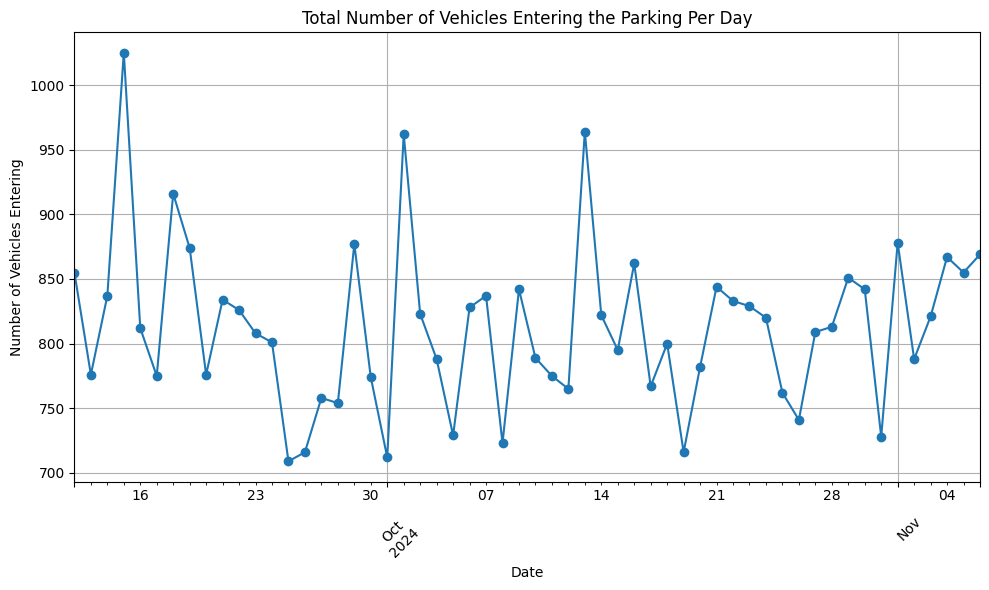

In [19]:


# Ensure 'in_time' is in datetime format
merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])

# 1. Extract the date from the 'in_time' column
merged_df['date'] = merged_df['in_time'].dt.date

# 2. Group by 'date' and count the number of entries per day
entries_daily = merged_df.groupby('date')['vehicle_no'].count()
entries_daily.index = pd.to_datetime(entries_daily.index)


# Sort the data by date (this step ensures it's chronological)
entries_daily = entries_daily.sort_index()

# 1. Split the data into train and test sets
# Use all but the last 7 days for training, and the last 7 days for testing
train_data = entries_daily.iloc[:-7]  # All data except the last 7 days
print(train_data)
test_data = entries_daily.iloc[-7:] 

# 3. Plot the total number of vehicles entering per day
plt.figure(figsize=(10, 6))
train_data.plot(kind='line', marker='o')
plt.title('Total Number of Vehicles Entering the Parking Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entering')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    :param y_true: Array-like, true values
    :param y_pred: Array-like, predicted values
    :return: float, MASE value
    """
    # Calculate the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase


In [35]:
## ARIMA predictions
model_auto_arima = AutoARIMA(sp=30, suppress_warnings=True, seasonal=True)  # sp=1 assumes no seasonality, adjust if needed
model_auto_arima.fit(train_data)

forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])
mase_arima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_auto_arima)
mape_arima = mean_absolute_percentage_error(test_data, forecast_auto_arima)

print("ARIMA MAPE:", mape_arima)
print("ARIMA MASE:", mase_arima)

ARIMA MAPE: 0.05658211678334914
ARIMA MASE: 0.8321551512171154


In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Fit SARIMA model
sarima_model = SARIMAX(train_data, order=(4,4,5), seasonal_order=(1,1,2,7))  
sarima_fit = sarima_model.fit(disp=False)

# Forecasting
forecast_sarima = sarima_fit.forecast(steps=7)

# Evaluate
mase_sarima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_sarima)
mape_sarima = mean_absolute_percentage_error(test_data, forecast_sarima)

print("SARIMA MAPE:", mape_sarima)
print("SARIMA MASE:", mase_sarima)


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statesp

SARIMA MAPE: 0.060421995862650665
SARIMA MASE: 0.8714520529558493


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Fit Exponential Smoothing model without seasonality
exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()

# Forecasting
forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)

# Print the forecasted values
# print("Forecast from Non-Seasonal Exponential Smoothing:", forecast_exp_smoothing)
mape_exp_smoothing = mean_absolute_percentage_error(test_data, forecast_exp_smoothing)
mase_exp_smoothing = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_exp_smoothing)

print("exp smoothing MAPE:", mape_exp_smoothing)
print("exp smoothing MASE:", mase_exp_smoothing)

exp smoothing MAPE: 0.05431711999136996
exp smoothing MASE: 0.8026943841779994


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [72]:
from prophet import Prophet
import pandas as pd

# Prepare data for Prophet (it requires a DataFrame with columns "ds" and "y")
prophet_data = train_data.reset_index()
prophet_data.columns = ["ds", "y"]

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_data)

# Forecasting
future = prophet_model.make_future_dataframe(periods=7)
forecast_prophet = prophet_model.predict(future)

# Extract only forecasted values
forecast_values = forecast_prophet['yhat'][-7:].values

# Evaluate
mase_prophet = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_values)
mape_prophet = mean_absolute_percentage_error(test_data, forecast_values)

print("Prophet MAPE:", mape_prophet)
print("Prophet MASE:", mase_prophet)


18:54:32 - cmdstanpy - INFO - Chain [1] start processing
18:54:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 0.06272734091537671
Prophet MASE: 0.881524762702419


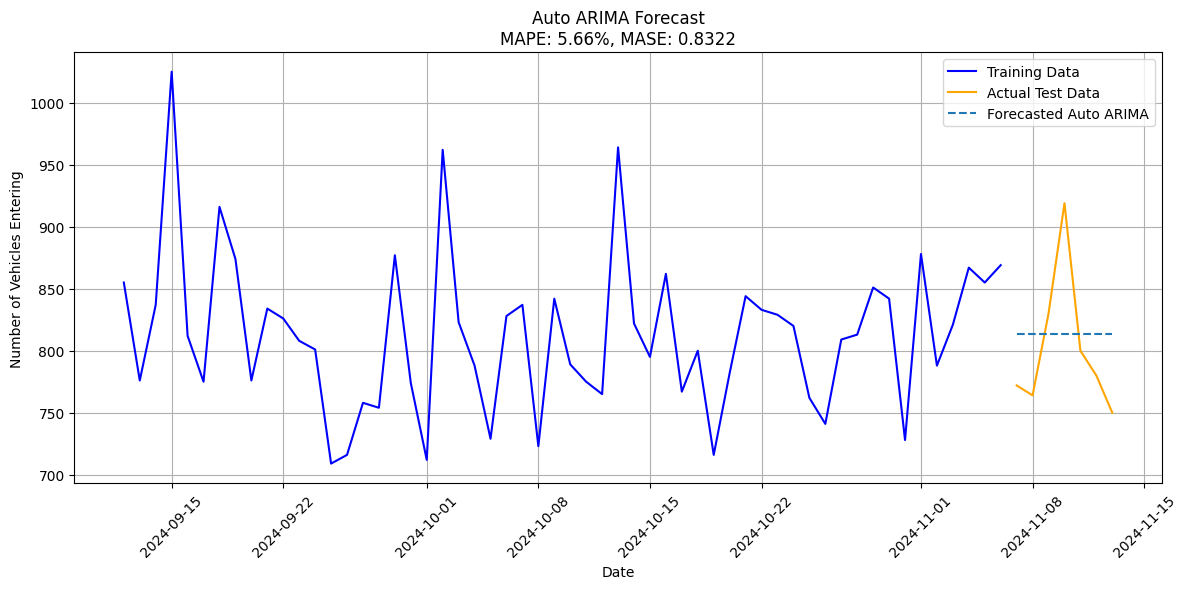

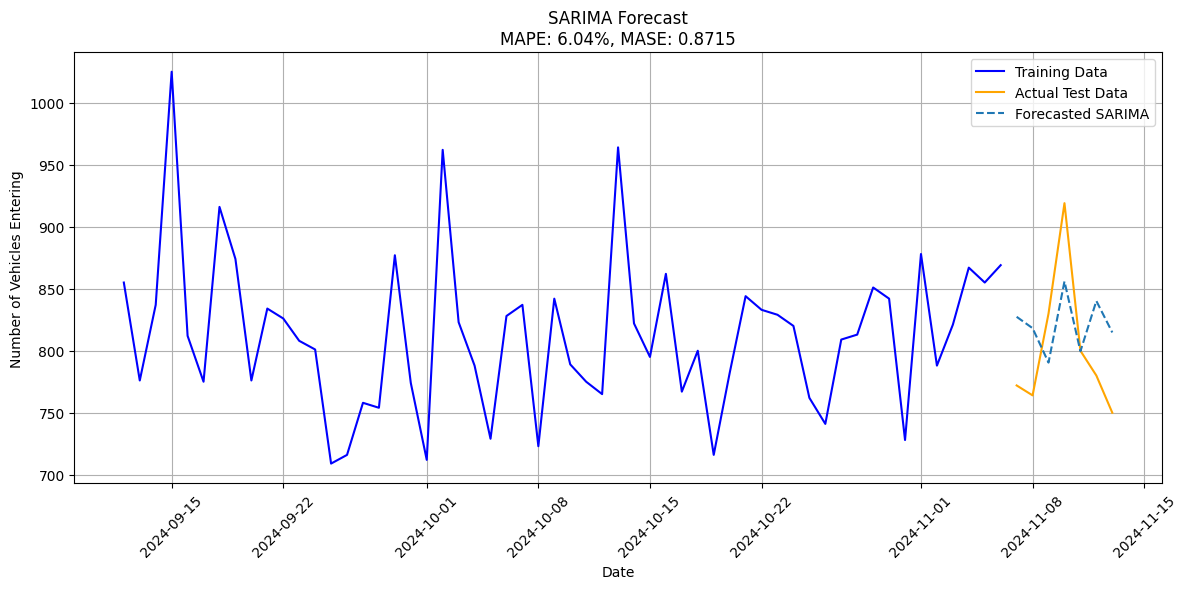

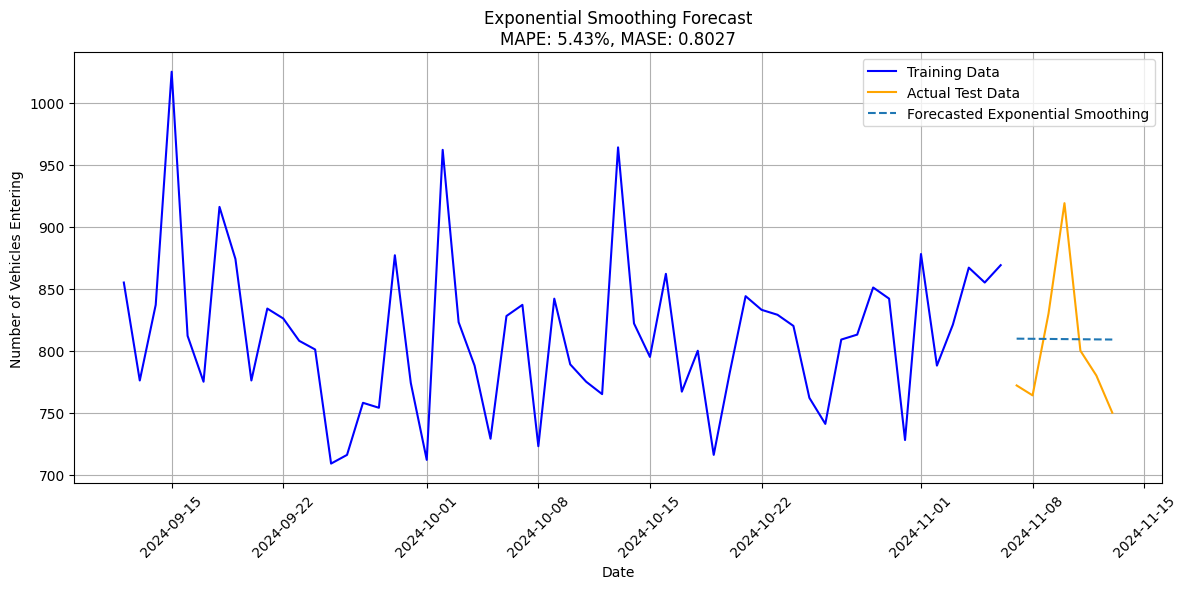

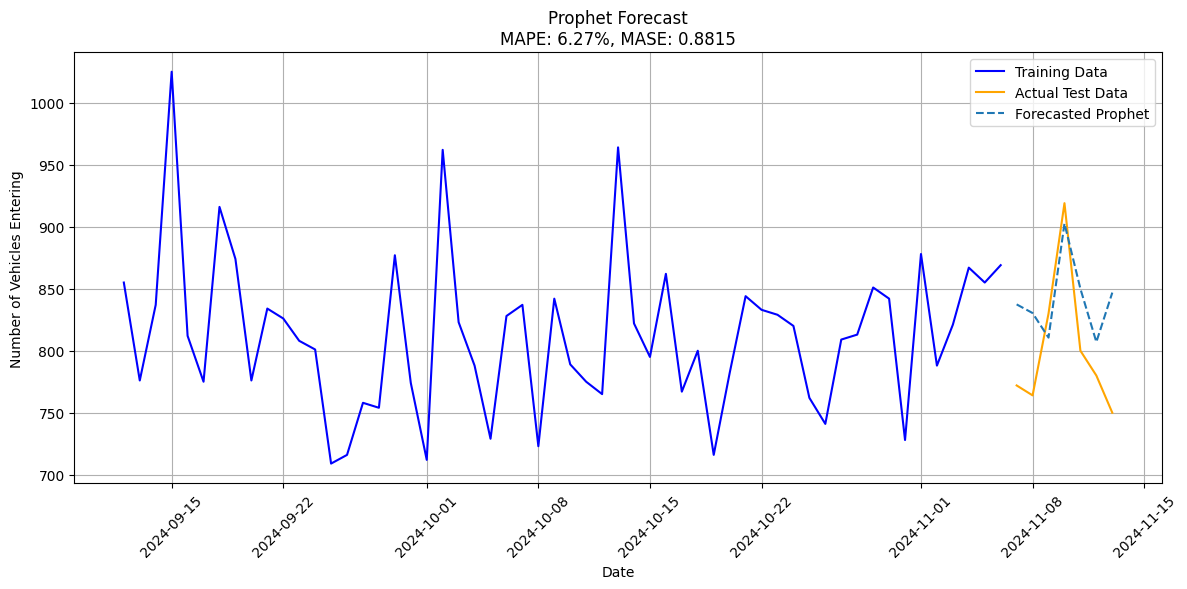

Forecasted values for the next 7 days:
            Auto ARIMA      SARIMA  Exponential Smoothing     Prophet
date                                                                 
2024-11-07  813.107143  827.365890             809.737015  837.370108
2024-11-08  813.107143  818.187171             809.618765  830.395456
2024-11-09  813.107143  790.423427             809.500514  810.562971
2024-11-10  813.107143  855.915718             809.382264  902.631089
2024-11-11  813.107143  799.561103             809.264014  849.954044
2024-11-12  813.107143  840.144466             809.145763  807.042328
2024-11-13  813.107143  814.745150             809.027513  846.876049


In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already computed the forecasts and MAPE, MASE for each model:
# forecast_auto_arima, forecast_sarima, forecast_exp_smoothing, forecast_prophet
# And test_data is available along with the calculated error metrics.

# Forecast data preparation
forecast_sarima = sarima_fit.forecast(steps=7)  # from SARIMA
forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)  # from Exponential Smoothing
forecast_prophet = forecast_prophet['yhat'][-7:].values  # from Prophet

# Collect forecasts and error metrics in a dictionary for easier looping
model_forecasts = {
    'Auto ARIMA': (forecast_auto_arima, mape_arima, mase_arima),
    'SARIMA': (forecast_sarima, mape_sarima, mase_sarima),
    'Exponential Smoothing': (forecast_exp_smoothing, mape_exp_smoothing, mase_exp_smoothing),
    'Prophet': (forecast_prophet, mape_prophet, mase_prophet)
}

# Plot each model's forecast with MAPE and MASE in the title
for model_name, (forecast, mape, mase) in model_forecasts.items():
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
    plt.plot(test_data.index[-7:], forecast, label=f"Forecasted {model_name}", linestyle='--')

    plt.title(f'{model_name} Forecast\nMAPE: {mape:.2%}, MASE: {mase:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print forecasted values for the next 7 days
forecast_df = pd.DataFrame({
    'Auto ARIMA': forecast_auto_arima,
    'SARIMA': forecast_sarima,
    'Exponential Smoothing': forecast_exp_smoothing,
    'Prophet': forecast_prophet
}, index=test_data.index)

print("Forecasted values for the next 7 days:")
print(forecast_df)


In [29]:
merged_df['time_spent'] = (merged_df['exit_time'] - merged_df['in_time']).dt.total_seconds() / 3600  # convert to hours


# print(merged_data['time_spent'].max())
# print(merged_data['time_spent'].min())

avg_time_spent = merged_df.groupby(by=merged_df['in_time'].dt.date)['time_spent'].mean()


y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))

y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)



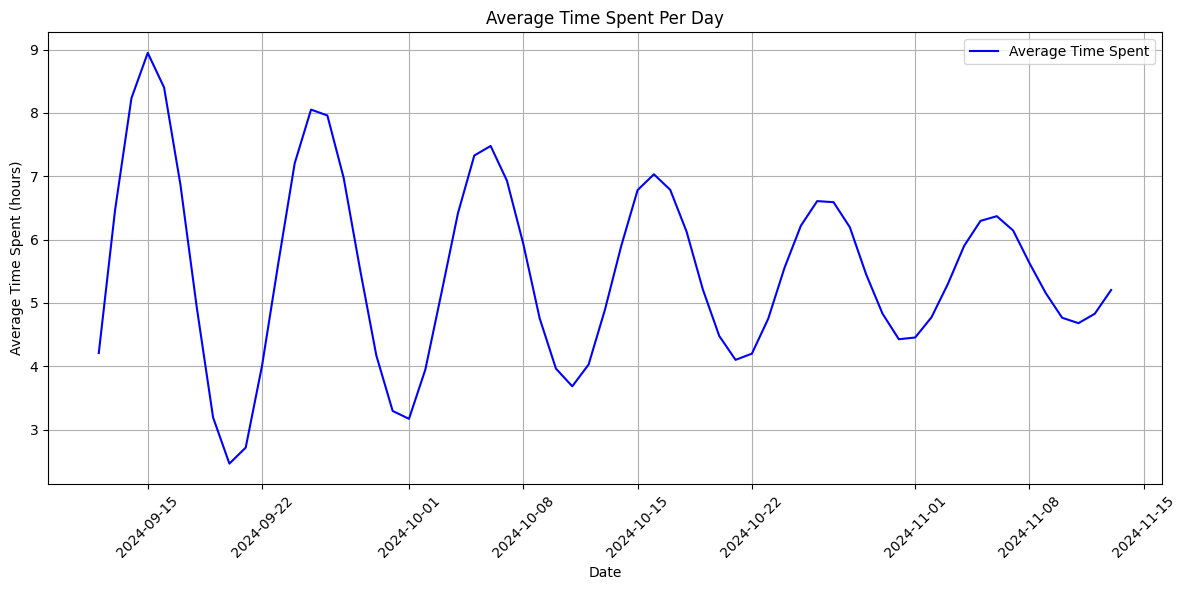

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming avg_time_spent is a pandas Series where the index represents dates and values represent average time spent
# Convert 'avg_time_spent' to a DataFrame if needed (for better flexibility with plotting)

# Plot the actual average time spent per day without any predictions
plt.figure(figsize=(12, 6))
plt.plot(y_time.index, y_time['time_spent'], label="Average Time Spent", color='blue')

# Formatting the plot
plt.title('Average Time Spent Per Day')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (hours)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
model_time.fit(y=y_train_time)

y_pred_time = model_time.predict(fh=np.arange(1, 8))

sarimax_model = SARIMAX(endog=y_train_time, order=(2,4,3), seasonal_order=(1,1,2,9) ) 
sarimax_result = sarimax_model.fit()
y_pred_time_sarima = sarimax_result.forecast(steps=7)

mae = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)

# Calculate MAPE using the function, not the class
mape = mean_absolute_percentage_error(y_test_time, y_pred_time)


mase_s = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time_sarima)

# Calculate MAPE using the function, not the class
mape_s = mean_absolute_percentage_error(y_test_time, y_pred_time_sarima)

print(f"MASE: {mase:.4f}")    # Output with 4 decimal places
print(f"MAPE: {mape * 100:.2f}%")  # MAPE in percentage format

print(f"MASE_S: {mase_s:.4f}")    # Output with 4 decimal places
print(f"MAPE_S: {mape_s * 100:.2f}%")  # MAPE in percentage format



c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MASE: 0.8322
MAPE: 1.55%
MASE_S: 5.3912
MAPE_S: 35.95%


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


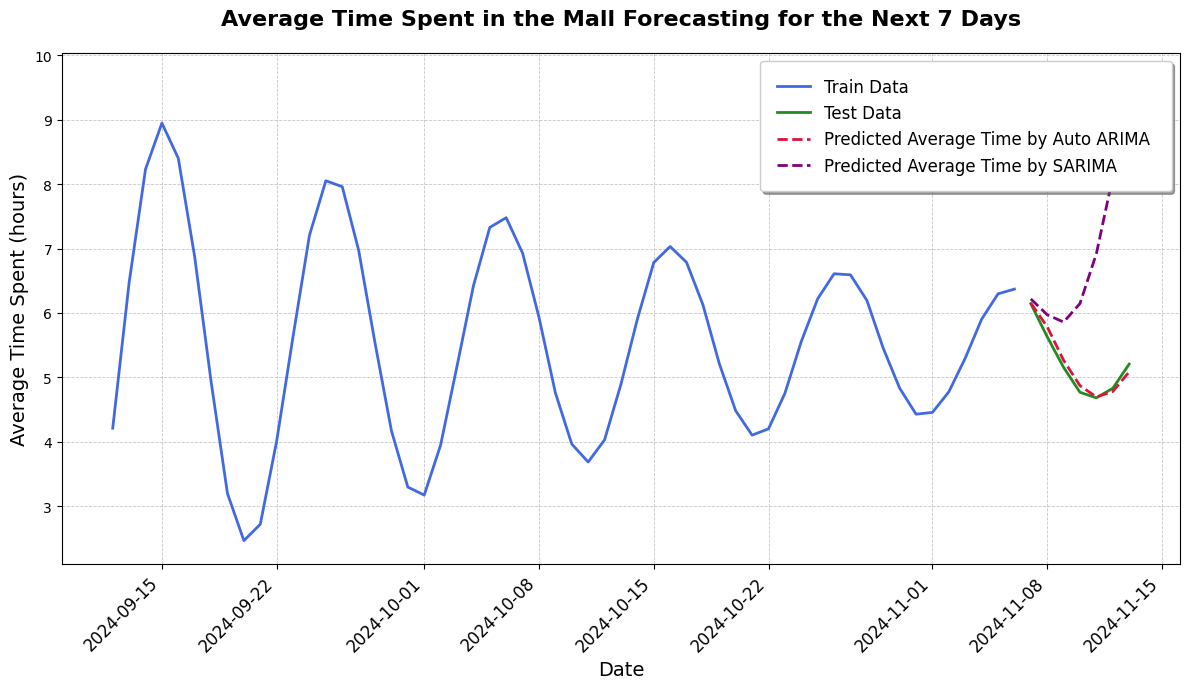

In [32]:
plt.figure(figsize=(12, 7))

plt.plot(y_train_time.index, y_train_time, label="Train Data", color='royalblue', linewidth=2)
plt.plot(y_test_time.index, y_test_time, label="Test Data", color='forestgreen', linewidth=2)

future_dates_time = pd.date_range(start=y_time.index[-8] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates_time, y_pred_time, label="Predicted Average Time by Auto ARIMA ", color='crimson', linestyle='--', linewidth=2)
plt.plot(future_dates_time, y_pred_time_sarima, label="Predicted Average Time by SARIMA", color='purple', linestyle='--', linewidth=2)


plt.title('Average Time Spent in the Mall Forecasting for the Next 7 Days', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Time Spent (hours)', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True, borderpad=1)
plt.tight_layout()

plt.show()


In [74]:
# Cell 3: AutoARIMA Model Training and Forecasting
model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
model_time.fit(y=y_train_time)

# Forecasting
y_pred_time = model_time.predict(fh=np.arange(1, 8))

# Calculate MASE and MAPE for AutoARIMA
mase_arima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
mape_arima = mean_absolute_percentage_error(y_test_time, y_pred_time)

# Print Results
print("AutoARIMA MASE:", mase_arima)
print("AutoARIMA MAPE:", mape_arima * 100)


AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


In [75]:
# Cell 4: SARIMAX Model Training and Forecasting
sarimax_model = SARIMAX(endog=y_train_time, order=(2,4,3), seasonal_order=(1,1,2,9))
sarimax_result = sarimax_model.fit(disp=False)

# Forecasting
y_pred_time_sarima = sarimax_result.forecast(steps=7)

# Calculate MASE and MAPE for SARIMAX
mase_sarima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time_sarima)
mape_sarima = mean_absolute_percentage_error(y_test_time, y_pred=y_pred_time_sarima)

# Print Results
print("SARIMAX MASE:", mase_sarima)
print("SARIMAX MAPE:", mape_sarima * 100)


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX MASE: 5.391213320485454
SARIMAX MAPE: 35.946506358569856


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
# Cell 5: Prophet Model Training and Forecasting
# Prepare data for Prophet (it requires a DataFrame with columns "ds" and "y")
prophet_data = y_train_time.reset_index()
prophet_data.columns = ["ds", "y"]

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_data)

# Forecasting
future = prophet_model.make_future_dataframe(periods=7, freq='D')
forecast_prophet = prophet_model.predict(future)
forecast_values_prophet = forecast_prophet['yhat'][-7:].values

# Calculate MASE and MAPE for Prophet
mase_prophet = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_values_prophet)
mape_prophet = mean_absolute_percentage_error(y_test_time, forecast_values_prophet)

# Print Results
print("Prophet MASE:", mase_prophet)
print("Prophet MAPE:", mape_prophet * 100)


19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing


Prophet MASE: 1.7901104642551435
Prophet MAPE: 11.284890842821685


In [77]:
# Cell 6: Exponential Smoothing Model Training and Forecasting
exp_smoothing_model = ExponentialSmoothing(y_train_time, trend='add', seasonal='add', seasonal_periods=7).fit()

# Forecasting
forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)

# Calculate MASE and MAPE for Exponential Smoothing
mase_exp_smoothing = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_exp_smoothing)
mape_exp_smoothing = mean_absolute_percentage_error(y_test_time, forecast_exp_smoothing)

# Print Results
print("Exponential Smoothing MASE:", mase_exp_smoothing)
print("Exponential Smoothing MAPE:", mape_exp_smoothing * 100)


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


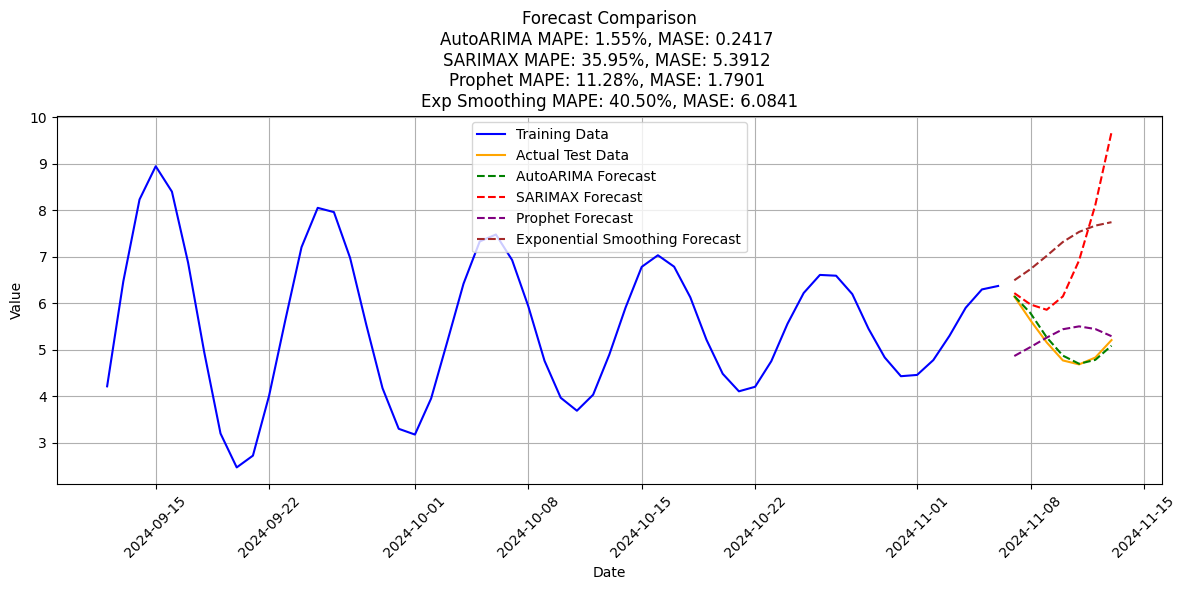

In [78]:
# Cell 7: Visualization of Forecasts
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(y_train_time.index, y_train_time, label="Training Data", color='blue')
# Plot test data
plt.plot(y_test_time.index, y_test_time, label="Actual Test Data", color='orange')

# Plot forecasts from each model
plt.plot(y_test_time.index, y_pred_time, label="AutoARIMA Forecast", linestyle='--', color='green')
plt.plot(y_test_time.index, y_pred_time_sarima, label="SARIMAX Forecast", linestyle='--', color='red')
plt.plot(y_test_time.index, forecast_values_prophet, label="Prophet Forecast", linestyle='--', color='purple')
plt.plot(y_test_time.index, forecast_exp_smoothing, label="Exponential Smoothing Forecast", linestyle='--', color='brown')

# Adding titles and labels
plt.title(f'Forecast Comparison\n'
          f'AutoARIMA MAPE: {mape_arima * 100:.2f}%, MASE: {mase_arima:.4f} \n'
          f'SARIMAX MAPE: {mape_sarima * 100:.2f}%, MASE: {mase_sarima:.4f} \n'
          f'Prophet MAPE: {mape_prophet * 100:.2f}%, MASE: {mase_prophet:.4f} \n'
          f'Exp Smoothing MAPE: {mape_exp_smoothing * 100:.2f}%, MASE: {mase_exp_smoothing:.4f}')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
